# Day 11

## Part 1

We need to run an Intcode program, to paint some grid.
The program:
1. takes 0 or 1 as input if the current cell is black or white
2. outputs 0 or 1 if the cell should be paint in black or white
3. outputs 0 or 1 to turn left or right
4. move one cell forward
5. loops

Let's reuse our Intcode interpreter from day9.

In [ ]:
%autoawait trio

In [2]:
from collections import defaultdict

import trio


class Computer:
    def __init__(self, program):
        self.position = 0
        self.relative_base = 0
        self.parameters_mode = None
        self.program = program.copy()

    def set_input_output(self, buffer_max=10):
        input_write, input_read = trio.open_memory_channel(buffer_max)
        output_write, output_read = trio.open_memory_channel(buffer_max)
        
        self.input, self.output = input_read, output_write
        
        return input_write, output_read
        
    @staticmethod
    def log(*args):
        if False:
            print(*args)

    def get_param_value(self, param):
        param_address = self.get_param_address(param)
        
        try:
            value = self.program[param_address]
        except IndexError:
            self.extend(param_address)
            value = self.program[param_address]
            
        return value

    def get_param_address(self, param):
        mode = self.parameters_mode[param]

        if mode == 0:  # position mode
            return self.program[self.position + param]
        elif mode == 1:  # immediate mode
            return self.position + param
        elif mode == 2:  # relative mode:
            param_position = self.position + param
            return self.relative_base + self.program[param_position]
        else:
            raise ValueError("Unknown paremeter mode")

    def read_instruction(self):
        # read instruction and split it into opcode and parameters mode
        try:
            instruction = self.program[self.position]
        except IndexError:
            # end of program
            return None

        opcode = instruction % 100
        self.parameters_mode = defaultdict(lambda: 0)

        value = instruction // 100
        i = 1
        while value > 0:
            self.parameters_mode[i] = value % 10
            value //= 10
            i += 1

        self.log(self.position, '>', instruction, opcode, dict(self.parameters_mode))
        return opcode
    
    def write(self, address, value):
        try:
            self.program[address] = value
        except IndexError:
            self.extend(address)
            self.program[address] = value
            
    def extend(self, address):
        self.program.extend([0] * (1 + address - len(self.program)))

    async def compute_close(self):
        """Run the programm, but close the output when terminated."""
        async with self.output:
            await self.compute()
            
        
    async def compute(self):
        """Compute the final state of a program, and return it.

        `program` is a list of int.
        `read_input` is a method returning a value each time it is called.
        `write_output` is a method taking a value as parameter.
        """
        # init state
        self.position = 0

        # run program
        while True:
            opcode = self.read_instruction()
            if opcode is None:
                # end of program
                log("Stop: EOF")
                return

            # execute opcode
            if opcode == 1:
                # add x y
                x = self.get_param_value(1)
                y = self.get_param_value(2)
                result_addr = self.get_param_address(3)

                result = x + y
                self.write(result_addr, result)
                self.log("add", x, y, result_addr, result)

                step = 4
            elif opcode == 2:
                # mult x y
                x = self.get_param_value(1)
                y = self.get_param_value(2)
                result_addr = self.get_param_address(3)

                result = x * y
                self.write(result_addr, result)
                self.log("mult", x, y, result_addr, result)

                step = 4
            elif opcode == 3:
                # read x
                result_addr = self.get_param_address(1)

                value = await self.input.receive()
                self.write(result_addr, value)
                self.log("read", value, result_addr)

                step = 2
            elif opcode == 4:
                # write x
                value = self.get_param_value(1)
                await self.output.send(value)
                self.log("write", value)

                step = 2
            elif opcode == 5:
                # jump-if-true x y
                value = self.get_param_value(1)
                jump_addr = self.get_param_value(2)

                self.log("jump-if-true", value, jump_addr)

                if value:
                    self.position = jump_addr
                    step = 0
                else:
                    step = 3
            elif opcode == 6:
                # jump-if-false x y
                value = self.get_param_value(1)
                jump_addr = self.get_param_value(2)

                self.log("jump-if-false", value, jump_addr)

                if not value:
                    self.position = jump_addr
                    step = 0
                else:
                    step = 3
            elif opcode == 7:
                # lt x y z
                x = self.get_param_value(1)
                y = self.get_param_value(2)
                result_addr = self.get_param_address(3)

                self.log("lt", x, y, result_addr)

                if x < y:
                    self.write(result_addr, 1)
                else:
                    self.write(result_addr, 0)

                step = 4
            elif opcode == 8:
                # eq x y z
                x = self.get_param_value(1)
                y = self.get_param_value(2)
                result_addr = self.get_param_address(3)

                self.log("eq", x, y, result_addr)

                if x == y:
                    self.write(result_addr, 1)
                else:
                    self.write(result_addr, 0)

                step = 4
            elif opcode == 9:
                # relative_base_add x
                x = self.get_param_value(1)
                self.relative_base += x
                
                self.log("relative_base_add", x)
                
                step = 2
            elif opcode == 99:
                # end of program
                self.log("stop")
                break
            else:
                # unknown instruction
                self.log("unknown opcode")
                break

            self.position += step

        return self.program

We need to count how many cells are painted at least once.

In [3]:
from collections import defaultdict, namedtuple

Point = namedtuple("Point", ("x", "y"))

In [4]:
def turn_right(direction):
    """Return the new direction turned 90° to the right."""
    return Point(direction.y, direction.x * -1)

In [5]:
turn_right(Point(0, 1))

Point(x=1, y=0)

In [6]:
turn_right(Point(1, 0))

Point(x=0, y=-1)

In [7]:
turn_right(Point(0, -1))

Point(x=-1, y=0)

In [8]:
turn_right(Point(-1, 0))

Point(x=0, y=1)

In [9]:
def turn_left(direction):
    """Return the new direction turned 90° to the right."""
    return Point(direction.y * -1, direction.x)

In [10]:
turn_left(Point(0, 1))

Point(x=-1, y=0)

In [11]:
turn_left(Point(-1, 0))

Point(x=0, y=-1)

In [12]:
turn_left(Point(0, -1))

Point(x=1, y=0)

In [13]:
turn_left(Point(1, 0))

Point(x=0, y=1)

In [14]:
async def manage_computer(input_, output, result):
    grid = defaultdict(lambda: 0)
    
    cell = Point(0, 0)
    direction = Point(0, 1)  # we start facing up
    
    # init
    await input_.send(grid[cell])
    
    # to close output when we exit
    async with output:
        async for value in output:
            # the first value is the color to paint
            grid[cell] = value
            
            # the second is to turn left or right
            turn = await output.receive()
            if turn == 0:
                direction = turn_left(direction)
            else:
                direction = turn_right(direction)
                
            cell = Point(
                cell.x + direction.x,
                cell.y + direction.y,
            )
            
            # send new cell color
            await input_.send(grid[cell])
            
    await result.send(grid)

In [15]:
program = [3,8,1005,8,319,1106,0,11,0,0,0,104,1,104,0,3,8,102,-1,8,10,1001,10,1,10,4,10,108,1,8,10,4,10,101,0,8,28,2,1105,12,10,1006,0,12,3,8,102,-1,8,10,101,1,10,10,4,10,1008,8,0,10,4,10,102,1,8,58,2,107,7,10,1006,0,38,2,1008,3,10,3,8,1002,8,-1,10,1001,10,1,10,4,10,108,0,8,10,4,10,1001,8,0,90,3,8,1002,8,-1,10,101,1,10,10,4,10,108,0,8,10,4,10,101,0,8,112,1006,0,65,1,1103,1,10,1006,0,91,3,8,102,-1,8,10,101,1,10,10,4,10,108,1,8,10,4,10,101,0,8,144,1006,0,32,3,8,1002,8,-1,10,101,1,10,10,4,10,108,1,8,10,4,10,102,1,8,169,1,109,12,10,1006,0,96,1006,0,5,3,8,102,-1,8,10,1001,10,1,10,4,10,108,1,8,10,4,10,101,0,8,201,3,8,102,-1,8,10,1001,10,1,10,4,10,108,0,8,10,4,10,1001,8,0,223,1,4,9,10,2,8,5,10,1,3,4,10,3,8,1002,8,-1,10,1001,10,1,10,4,10,108,1,8,10,4,10,101,0,8,257,1,1,9,10,1006,0,87,3,8,102,-1,8,10,1001,10,1,10,4,10,1008,8,0,10,4,10,102,1,8,287,2,1105,20,10,1,1006,3,10,1,3,4,10,101,1,9,9,1007,9,1002,10,1005,10,15,99,109,641,104,0,104,1,21102,1,932972962600,1,21101,0,336,0,1106,0,440,21101,838483681940,0,1,21101,0,347,0,1106,0,440,3,10,104,0,104,1,3,10,104,0,104,0,3,10,104,0,104,1,3,10,104,0,104,1,3,10,104,0,104,0,3,10,104,0,104,1,21101,3375393987,0,1,21101,394,0,0,1105,1,440,21102,46174071847,1,1,21102,1,405,0,1106,0,440,3,10,104,0,104,0,3,10,104,0,104,0,21101,988648461076,0,1,21101,428,0,0,1106,0,440,21101,0,709580452200,1,21101,439,0,0,1105,1,440,99,109,2,22101,0,-1,1,21101,40,0,2,21102,1,471,3,21102,461,1,0,1106,0,504,109,-2,2106,0,0,0,1,0,0,1,109,2,3,10,204,-1,1001,466,467,482,4,0,1001,466,1,466,108,4,466,10,1006,10,498,1102,0,1,466,109,-2,2105,1,0,0,109,4,1202,-1,1,503,1207,-3,0,10,1006,10,521,21102,1,0,-3,22102,1,-3,1,21201,-2,0,2,21101,0,1,3,21102,540,1,0,1106,0,545,109,-4,2106,0,0,109,5,1207,-3,1,10,1006,10,568,2207,-4,-2,10,1006,10,568,22101,0,-4,-4,1105,1,636,22102,1,-4,1,21201,-3,-1,2,21202,-2,2,3,21102,1,587,0,1105,1,545,22101,0,1,-4,21102,1,1,-1,2207,-4,-2,10,1006,10,606,21101,0,0,-1,22202,-2,-1,-2,2107,0,-3,10,1006,10,628,21201,-1,0,1,21101,0,628,0,106,0,503,21202,-2,-1,-2,22201,-4,-2,-4,109,-5,2106,0,0]

computer = Computer(program)
input_, output = computer.set_input_output()

result_write, result_read = trio.open_memory_channel(1)

async with trio.open_nursery() as nursery:
    nursery.start_soon(manage_computer, input_, output, result_write)
    nursery.start_soon(computer.compute_close)

grid = await result_read.receive()

In [16]:
len(grid) - 1  # the last cell is not painted

2211

## Part 2

We made a mistake, the painting robot need to start on a **white** cell.

In [17]:
async def manage_computer(input_, output, result):
    grid = defaultdict(lambda: 0)
    
    cell = Point(0, 0)
    direction = Point(0, 1)  # we start facing up
    
    # init
    grid[cell] = 1
    await input_.send(grid[cell])
    
    # to close output when we exit
    async with output:
        async for value in output:
            # the first value is the color to paint
            grid[cell] = value
            
            # the second is to turn left or right
            turn = await output.receive()
            if turn == 0:
                direction = turn_left(direction)
            else:
                direction = turn_right(direction)
                
            cell = Point(
                cell.x + direction.x,
                cell.y + direction.y,
            )
            
            # send new cell color
            await input_.send(grid[cell])
            
    await result.send(grid)

In [18]:
program = [3,8,1005,8,319,1106,0,11,0,0,0,104,1,104,0,3,8,102,-1,8,10,1001,10,1,10,4,10,108,1,8,10,4,10,101,0,8,28,2,1105,12,10,1006,0,12,3,8,102,-1,8,10,101,1,10,10,4,10,1008,8,0,10,4,10,102,1,8,58,2,107,7,10,1006,0,38,2,1008,3,10,3,8,1002,8,-1,10,1001,10,1,10,4,10,108,0,8,10,4,10,1001,8,0,90,3,8,1002,8,-1,10,101,1,10,10,4,10,108,0,8,10,4,10,101,0,8,112,1006,0,65,1,1103,1,10,1006,0,91,3,8,102,-1,8,10,101,1,10,10,4,10,108,1,8,10,4,10,101,0,8,144,1006,0,32,3,8,1002,8,-1,10,101,1,10,10,4,10,108,1,8,10,4,10,102,1,8,169,1,109,12,10,1006,0,96,1006,0,5,3,8,102,-1,8,10,1001,10,1,10,4,10,108,1,8,10,4,10,101,0,8,201,3,8,102,-1,8,10,1001,10,1,10,4,10,108,0,8,10,4,10,1001,8,0,223,1,4,9,10,2,8,5,10,1,3,4,10,3,8,1002,8,-1,10,1001,10,1,10,4,10,108,1,8,10,4,10,101,0,8,257,1,1,9,10,1006,0,87,3,8,102,-1,8,10,1001,10,1,10,4,10,1008,8,0,10,4,10,102,1,8,287,2,1105,20,10,1,1006,3,10,1,3,4,10,101,1,9,9,1007,9,1002,10,1005,10,15,99,109,641,104,0,104,1,21102,1,932972962600,1,21101,0,336,0,1106,0,440,21101,838483681940,0,1,21101,0,347,0,1106,0,440,3,10,104,0,104,1,3,10,104,0,104,0,3,10,104,0,104,1,3,10,104,0,104,1,3,10,104,0,104,0,3,10,104,0,104,1,21101,3375393987,0,1,21101,394,0,0,1105,1,440,21102,46174071847,1,1,21102,1,405,0,1106,0,440,3,10,104,0,104,0,3,10,104,0,104,0,21101,988648461076,0,1,21101,428,0,0,1106,0,440,21101,0,709580452200,1,21101,439,0,0,1105,1,440,99,109,2,22101,0,-1,1,21101,40,0,2,21102,1,471,3,21102,461,1,0,1106,0,504,109,-2,2106,0,0,0,1,0,0,1,109,2,3,10,204,-1,1001,466,467,482,4,0,1001,466,1,466,108,4,466,10,1006,10,498,1102,0,1,466,109,-2,2105,1,0,0,109,4,1202,-1,1,503,1207,-3,0,10,1006,10,521,21102,1,0,-3,22102,1,-3,1,21201,-2,0,2,21101,0,1,3,21102,540,1,0,1106,0,545,109,-4,2106,0,0,109,5,1207,-3,1,10,1006,10,568,2207,-4,-2,10,1006,10,568,22101,0,-4,-4,1105,1,636,22102,1,-4,1,21201,-3,-1,2,21202,-2,2,3,21102,1,587,0,1105,1,545,22101,0,1,-4,21102,1,1,-1,2207,-4,-2,10,1006,10,606,21101,0,0,-1,22202,-2,-1,-2,2107,0,-3,10,1006,10,628,21201,-1,0,1,21101,0,628,0,106,0,503,21202,-2,-1,-2,22201,-4,-2,-4,109,-5,2106,0,0]

computer = Computer(program)
input_, output = computer.set_input_output()

result_write, result_read = trio.open_memory_channel(1)

async with trio.open_nursery() as nursery:
    nursery.start_soon(manage_computer, input_, output, result_write)
    nursery.start_soon(computer.compute_close)

grid = await result_read.receive()

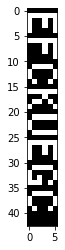

In [19]:
import numpy as np
from matplotlib import pyplot as plt

max_x = min_x = max_y = min_y = 0
for point in grid:
    max_x = max(point.x, max_x)
    min_x = min(point.x, min_x)
    max_y = max(point.y, max_y)
    min_y = min(point.y, min_y)
    
data = np.zeros((max_x - min_x + 1, max_y - min_y + 1, 3), dtype=np.uint8)
for point in grid:
    x = point.x - min_x
    y = point.y - min_y
    
    if grid[point] == 0:
        color = (0, 0, 0)
    else:
        color = (255, 255, 255)

    data[x, y] = color

plt.imshow(data)